# To do: take better measurements of the Fisher information.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns

import numpy as np
import pandas as pd

from tqdm import tqdm

import sys
sys.path.append('../src')
from scipy.stats import vonmises

In [2]:
from models.face_angle import EstimateAngle

W1026 10:30:24.138000 77468 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


import error: No module named 'triton'


## How many samples do we need to evaluate Fisher information?

In [15]:
import torch
import numpy as np
import warnings

from data.rotated_faces import ConsistentRotationDataset

from sklearn.model_selection import StratifiedKFold
from sklearn.covariance import MinCovDet
from scipy.spatial.distance import mahalanobis


from tqdm import tqdm


class ActivityRecord():
    """Recorder to capture internal model activity"""
    def __init__(self, module):
        self.activity = {}
        self.hooks = module.register_forward_hook(self.record_activity)

        self.activity = {}
        self.key = 'none'

    def set_key(self, key):
        self.key = key

    def record_activity(self, module, input, output):
        key = self.key
        output = output.detach().clone()

        if key not in self.activity:
            self.activity[key] = output
        else: 
            self.activity[key] = torch.concat([self.activity[key], output])

    def clear_record(self):
        self.activity = {}

class DiscriminationAnalysis():
    """DiscriminationAnalysis: holder for the discrimination based Fisher information 
    analyses

    To do: Update this to use robust statistic for FI measurements
    """
    def __init__(self, model, module):
        self.model = model
        self.module = module

        self.recorder = ActivityRecord(module)
        self.N_samples = 19867

    def get_activity(self, midpoint, delta):
        """ performance of linear discriminator on internal activity data"""
        ds1 = ConsistentRotationDataset(midpoint-delta/2, split='valid')
        ds2 = ConsistentRotationDataset(midpoint+delta/2, split='valid')

        N_samples = self.N_samples
        if N_samples < len(ds1):
            inds1 = torch.randperm(10000)[0:N_samples]
            inds2 = torch.randperm(10000)[0:N_samples]

            ds1 = torch.utils.data.Subset(ds1, inds1)
            ds2 = torch.utils.data.Subset(ds2, inds2)

        dl1 = torch.utils.data.DataLoader(ds1, batch_size=32,
                                          num_workers=1
                                          )
        dl2 = torch.utils.data.DataLoader(ds2, batch_size=32,
                                          num_workers=1
                                          )

        self.recorder.set_key(0)
        for batch in iter(dl1):
            self.model.forward(batch[0].to(self.model.device))

        self.recorder.set_key(1)
        for batch in iter(dl2):
            self.model.forward(batch[0].to(self.model.device))

        l1 = len(self.recorder.activity[0])
        l2 = len(self.recorder.activity[1])
        all_embeddings = torch.concat([self.recorder.activity[0].view(l1, -1),
                                       self.recorder.activity[1].view(l2, -1)]
                                      ).cpu()
        labels = torch.concat([torch.zeros(l1), torch.ones(l2)])

        self.recorder.clear_record()
        return all_embeddings, labels

    def discrimination_performance(self, center, delta):
        data, labels = self.get_activity(center, delta)

        mcd0 = MinCovDet().fit(data[labels == 0])
        mu_robust0 = mcd0.location_
        cov_robust0 = mcd0.covariance_
        
        mcd1 = MinCovDet().fit(data[labels == 1])
        mu_robust1 = mcd1.location_
        cov_robust1 = mcd1.covariance_

        return mahalanobis(mu_robust0, mu_robust1, np.linalg.inv(0.5*cov_robust1 + 0.5*cov_robust0))

    def Fisher_info(self, angles, delta=0.03):
        """ Single point Fisher information.
            Future work: update to use multiple deltas
        """
        FIs = []
        for angle in tqdm(angles):
            dprime = self.discrimination_performance(angle, delta)
            FIs.append(dprime/delta)
        return np.array(FIs)


In [16]:
ckpt = '../experiments/multirun/2025-10-18(12:17:56)_kappa_sweep/0_kappa_1.0/checkpoints/best.ckpt'

In [17]:
model = EstimateAngle.load_from_checkpoint(ckpt)
model = model.to('mps')

/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.5, which is newer than your current Lightning version: v2.4.0


In [18]:
model.device

device(type='mps')

In [19]:
analyzer = DiscriminationAnalysis(model, model.decoder[2])

In [20]:
analyzer.N_samples = 1000

In [21]:
angles = np.linspace(-np.pi, np.pi, 50)

In [22]:
analyzer.N_samples = 100

In [26]:
FI1 = analyzer.Fisher_info(np.zeros(20))

100%|█████████████████████████████████████████████| 20/20 [04:42<00:00, 14.12s/it]


In [27]:
analyzer.N_samples = 1000
FI2 = analyzer.Fisher_info(np.zeros(20))

100%|█████████████████████████████████████████████| 20/20 [05:47<00:00, 17.39s/it]


In [38]:
analyzer.N_samples = 10000
FI3 = analyzer.Fisher_info(np.zeros(20))

100%|█████████████████████████████████████████████| 20/20 [18:05<00:00, 54.30s/it]


In [29]:
np.var(FI1)

np.float64(159.03569473622838)

In [30]:
FI1.mean()

np.float64(75.8959041285212)

In [31]:
FI2.mean()

np.float64(71.36696455020643)

In [39]:
FI3.mean()

np.float64(70.25800006962157)

In [40]:
np.var(FI3)

np.float64(0.009494995011548355)

(array([1., 4., 2., 0., 0., 0., 6., 1., 0., 6.]),
 array([70.09443958, 70.12250315, 70.15056672, 70.17863029, 70.20669386,
        70.23475744, 70.26282101, 70.29088458, 70.31894815, 70.34701172,
        70.37507529]),
 <BarContainer object of 10 artists>)

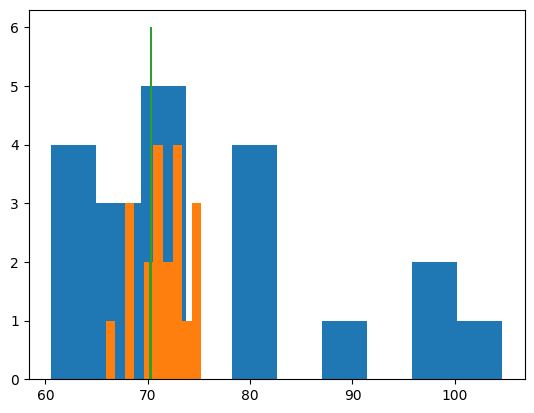

In [41]:
plt.hist(FI1)
plt.hist(FI2)
plt.hist(FI3)

In [ ]:
FI2 = analyzer.Fisher_info(angles)

In [ ]:
plt.plot(angles,FI1*0.03)
plt.plot(angles,FI2*0.03)

In [ ]:
plt.plot(angles, 0.03*(FI1 + FI2)/2)

In [21]:
ds1 = ConsistentRotationDataset(0-0.03/2, split='valid')

In [24]:
%prun
next(iter(ds1))

(tensor([[[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
 
         [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
 
         [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ...,

         3 function calls in 0.000 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)

## Analysis of implicit constraints

In [42]:
FIs_constraint = pd.read_parquet('constraint_fisher.parquet')

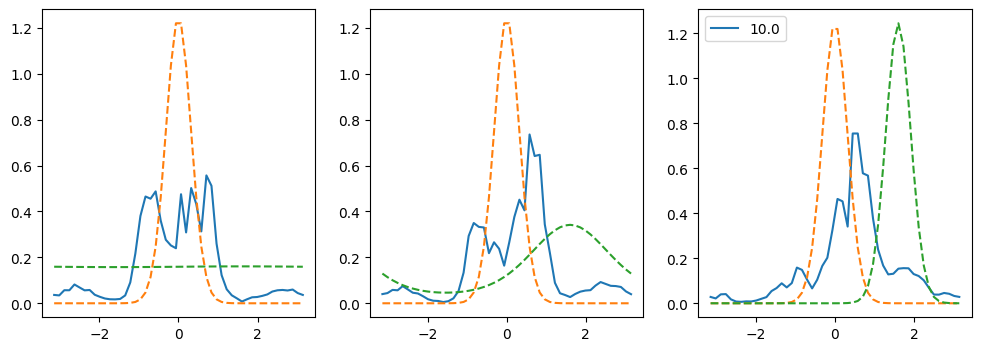

In [43]:
from scipy.stats import vonmises
def normalized_FI(FIs, delta=np.pi/25):
    return FIs / (FIs.sum() * delta)

figsize(12,4)
plt.subplots(1,3)
for i, row in FIs_constraint.iterrows():
    plt.subplot(1,3,i+1)
    plt.plot(angles, normalized_FI(row['fisher_info']**2), label=row['kappa'])

    dist_old = vonmises(loc=0, kappa=10)
    dist_new = vonmises(loc=1.6, kappa=row['kappa'])
    plt.plot(angles, dist_old.pdf(angles), '--')
    plt.plot(angles, dist_new.pdf(angles), '--')

plt.legend()

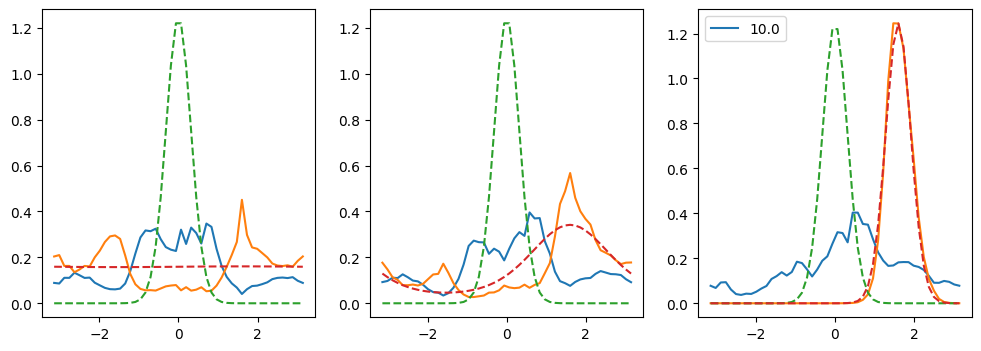

In [44]:
figsize(12,4)
plt.subplots(1,3)
for i, row in FIs_constraint.iterrows():
    plt.subplot(1,3,i+1)
    FIs = normalized_FI(row['fisher_info'])
    plt.plot(angles, FIs, label=row['kappa'])

    dist_old = vonmises(loc=0, kappa=10)
    dist_new = vonmises(loc=1.6, kappa=row['kappa'])
    prob_s = dist_new.pdf(angles)
    
    prob_theta = prob_s / FIs
    prob_theta = prob_theta / (prob_theta.sum()*np.pi/25)
    plt.plot(angles, prob_theta)
    

    plt.plot(angles, dist_old.pdf(angles), '--')
    plt.plot(angles, dist_new.pdf(angles), '--')

plt.legend()


In [50]:
from omegaconf import OmegaConf
from pathlib import Path

In [51]:
experiment_dir = Path('../experiments/multirun/2025-10-18(12:17:56)_kappa_sweep/0_kappa_1.0')
config = OmegaConf.load(experiment_dir / '.hydra/config.yaml')

In [55]:
a =pd.read_parquet('../experiment_data/denseFI_loss.parquet')

(10.0, 100.0)

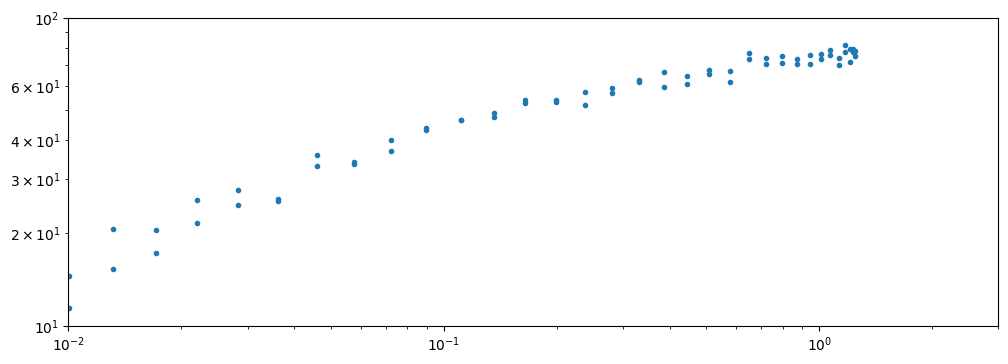

In [70]:
d = vonmises(loc=0., kappa=10.)
plt.loglog(d.pdf(np.linspace(-np.pi, np.pi, 200)), a['fisher_info'][0], '.')
plt.xlim([1e-2, 3])
plt.ylim([1e1, 1E2])

## loss functions

In [9]:
from scipy.stats import vonmises
angles = np.linspace(-np.pi, np.pi, 200)
FI_loss =pd.read_parquet('../experiment_data/denseFI_loss.parquet')


<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_1319/4188037219.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.title('$\sigma^{-1}$ = ' + f'{row['kappa']}', fontsize=16)


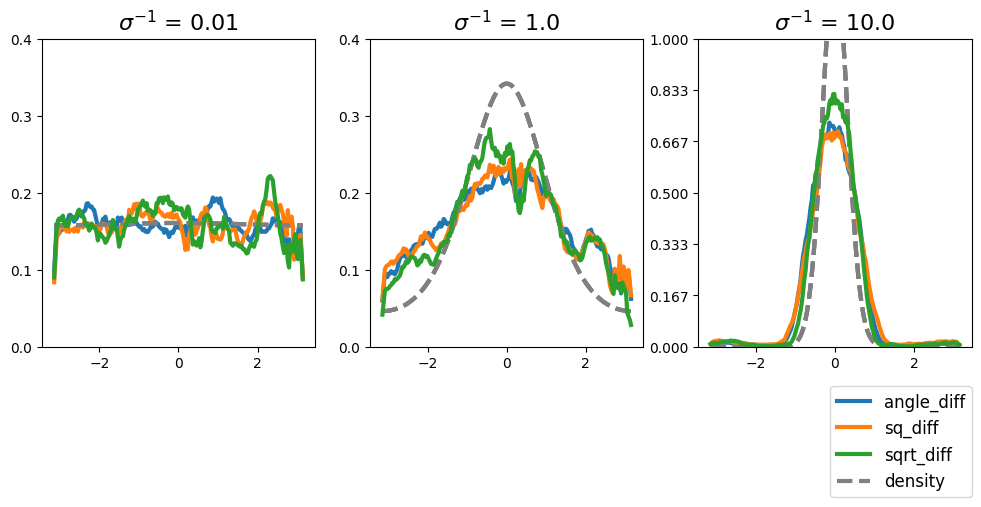

In [43]:
figsize(12,4)
plt.subplots(1,3)

from scipy.signal import savgol_filter

color_dict = {loss: f'C{i}' for i, loss in enumerate(['angle_diff', 'sq_diff', 'sqrt_diff'])}
plt.ylim([0, 100])

for loss in ['angle_diff', 'sq_diff', 'sqrt_diff']:
    for i, row in enumerate(FI_loss[FI_loss.loss == loss ].sort_values('kappa').iterrows()):
        row = row[1]
        plt.subplot(1,3,i+1)
    
        dist = vonmises(loc=0, kappa=row['kappa'])
        plt.plot(angles, dist.pdf(angles), '--', color='0.5', linewidth=3, label='density')

        normalized_FI = row['fisher_info']**2/((row['fisher_info']**2).sum()*np.pi/100) 
        N=5
        plt.plot(angles, np.convolve(normalized_FI, np.ones(N)/N, mode='same'),
                 color=color_dict[row['loss']], linewidth=3, label=row['loss'])
        plt.title('$\sigma^{-1}$ = ' + f'{row['kappa']}', fontsize=16)


        plt.ylim([0,0.4])
        plt.yticks(np.linspace(0, 0.4, 5))
        if i == 2:
            plt.ylim([0, 0.6])
            plt.yticks(np.linspace(0, 1.0, 7))




handles, labels = plt.gca().get_legend_handles_labels()
inds = [1,3,5,0]
handles = [handles[i] for i in inds]
labels = [labels[i] for i in inds]

plt.legend(handles, labels, bbox_to_anchor=(1.03, -.1), fontsize=12)

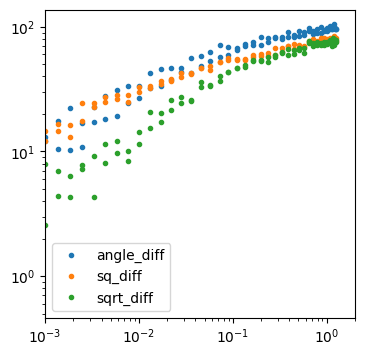

In [39]:
figsize(4,4)
for loss in ['angle_diff', 'sq_diff', 'sqrt_diff']:
    row = FI_loss[ (FI_loss.loss == loss) & (FI_loss.kappa ==10) ].iloc[0]


    dist = vonmises(loc=0, kappa=row['kappa'])
    FI = row['fisher_info']
    plt.loglog(dist.pdf(angles), FI, '.', label=row['loss'])

plt.xlim([1E-3, 2])

plt.legend()


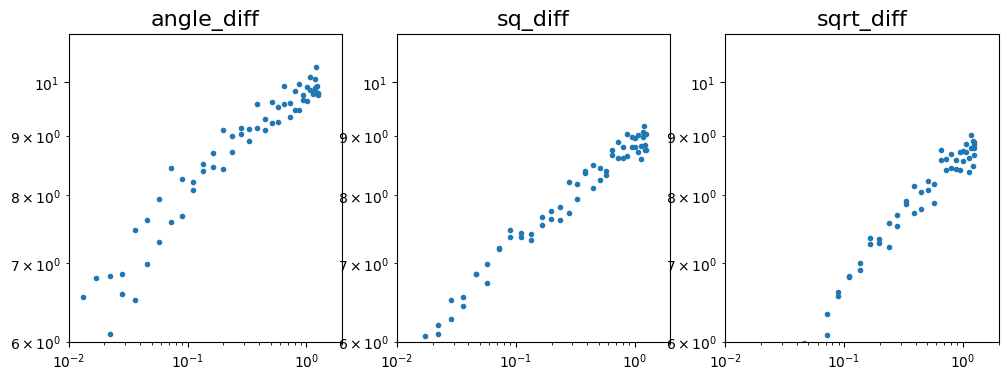

In [37]:
figsize(12,4)
plt.subplots(1,3)

color_dict = {loss: f'C{i}' for i, loss in enumerate(['angle_diff', 'sq_diff', 'sqrt_diff'])}

for i, loss in enumerate(['angle_diff', 'sq_diff', 'sqrt_diff']):
    for j, row in enumerate(FI_loss[FI_loss.loss == loss ].sort_values('kappa').iterrows()):
        row = row[1]
        plt.subplot(1,3,i+1)
    
        dist = vonmises(loc=0, kappa=row['kappa'])
        prob_s = dist.pdf(angles)
        FIs = row['fisher_info']

        if j == 2:
            plt.loglog(prob_s, FIs**0.5, '.', linewidth=3, label=row['loss'])
            plt.title(loss, fontsize=16)

        plt.xlim([1E-2, 2])
        plt.ylim(6, 11)
        

### Experiment design for better resolution:

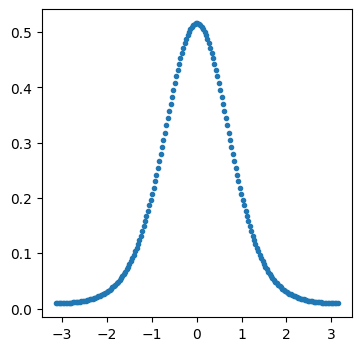

In [16]:
dist = vonmises(loc=0, kappa=2.)
plt.plot(angles, dist.pdf(angles), '.', label=row['loss'])

## Hard constraints

In [61]:
FI_constraint =pd.read_parquet('../experiment_data/hard_constraint_FI.parquet')

In [46]:
FI_constraint

,kappa,loss,fisher_info
0,0.01,2.0,"[2.273375479216941, 4.507436462081966, 2.58553..."
1,10.00,1.0,"[4.181908316369297, 5.5842105717514885, 5.0814..."
2,10.00,0.1,"[8.630660693558927, 6.849342949707861, 9.72363..."
3,1.00,2.0,"[5.1706462025874, 2.251439820358783, 0.9054908..."
4,1.00,1.0,"[7.601394825283676, 7.582404842058381, 5.79432..."
5,10.00,2.0,"[2.089948411384736, 4.577692186335419, 0.50399..."
6,0.01,1.0,"[7.32536923925839, 17.547560773316825, 13.1770..."
7,1.00,0.1,"[26.457415685791567, 27.019020169542227, 27.38..."
8,0.01,0.1,"[39.43248274490043, 42.17831363578811, 37.2010..."


<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_77468/2755515822.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.title('$\sigma^{-1}$ = ' + f'{row['kappa']}', fontsize=16)


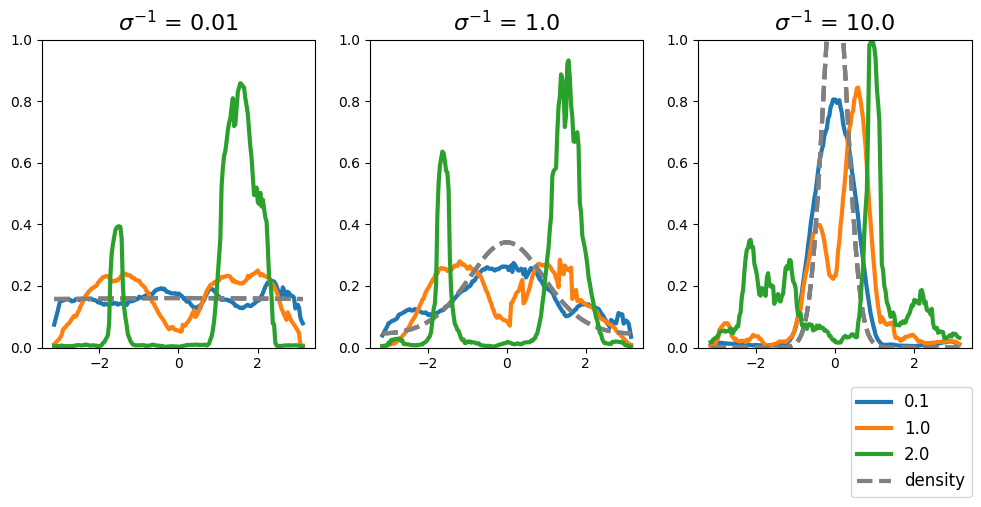

In [53]:
figsize(12,4)
plt.subplots(1,3)

from scipy.signal import savgol_filter

#color_dict = {loss: f'C{i}' for i, loss in enumerate(['angle_diff', 'sq_diff', 'sqrt_diff'])}
plt.ylim([0, 100])

for loss in [0.1, 1.0, 2.0]:
    for i, row in enumerate(FI_constraint[FI_constraint.loss == loss ].sort_values('kappa').iterrows()):
        row = row[1]
        plt.subplot(1,3,i+1)
    
        dist = vonmises(loc=0, kappa=row['kappa'])
        plt.plot(angles, dist.pdf(angles), '--', color='0.5', linewidth=3, label='density')

        normalized_FI = row['fisher_info']**2/((row['fisher_info']**2).sum()*np.pi/100) 
        N=10
        plt.plot(angles, np.convolve(normalized_FI, np.ones(N)/N, mode='same'),
                  linewidth=3, label=row['loss'])
        plt.title('$\sigma^{-1}$ = ' + f'{row['kappa']}', fontsize=16)


        plt.ylim([0,1.])




handles, labels = plt.gca().get_legend_handles_labels()
inds = [1,3,5,0]
handles = [handles[i] for i in inds]
labels = [labels[i] for i in inds]

plt.legend(handles, labels, bbox_to_anchor=(1.03, -.1), fontsize=12)

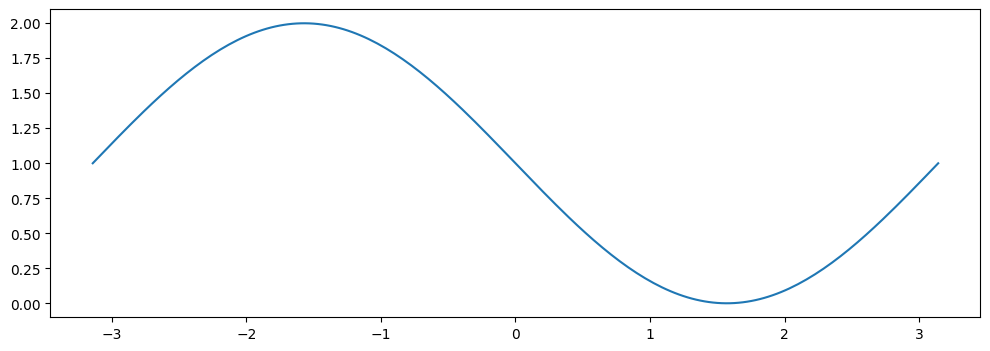

In [58]:
plt.plot(angles, 1.- np.sin(angles))

In [59]:
from models.face_angle import EstimateAngle

I think that the missing part of this analysis is the _density_ in the encoding space.

## Frozen layers.

In [21]:
from scipy.stats import vonmises
from models.face_angle import EstimateAngle
angles = np.linspace(-np.pi, np.pi, 200)
FI_pretrain =pd.read_parquet('../experiment_data/frozen_densr_FI.parquet')

W1026 18:39:09.703000 3764 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


import error: No module named 'triton'


In [11]:
FI_pretrain

,kappa,loss,fisher_info
0,1.00,angle_diff,"[6.627263477454807, 11.104363847553415, 4.9721..."
1,10.00,angle_diff,"[7.615143297851534, 9.542275947203592, 8.53097..."
2,0.01,angle_diff,"[6.524601220388672, 9.442882599152513, 5.93757..."


<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\s'
/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_3764/4023254882.py:23: SyntaxWarning: invalid escape sequence '\s'
  plt.title('$\sigma^{-1}$ = ' + f'{row['kappa']}', fontsize=16)


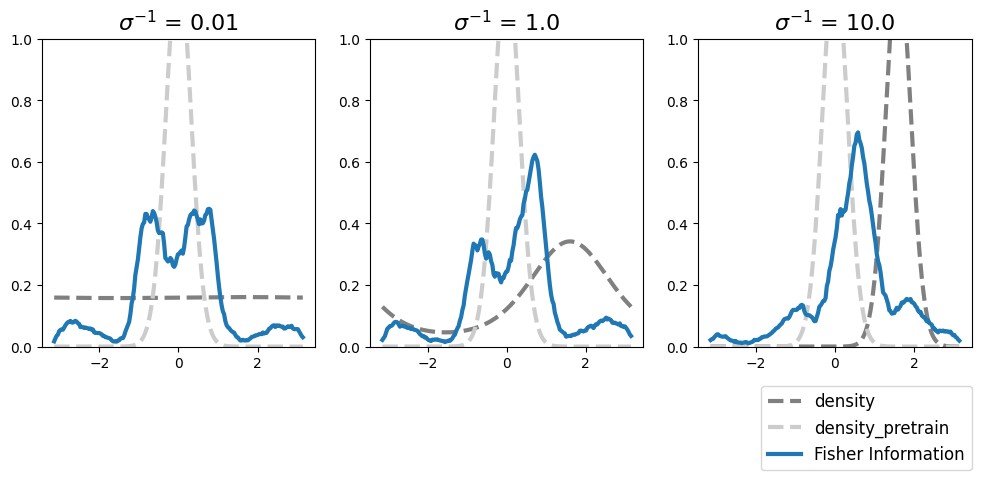

In [58]:
figsize(12,4)
plt.subplots(1,3)

from scipy.signal import savgol_filter

#color_dict = {loss: f'C{i}' for i, loss in enumerate(['angle_diff', 'sq_diff', 'sqrt_diff'])}
plt.ylim([0, 100])


for i, row in enumerate(FI_pretrain.sort_values('kappa').iterrows()):
    row = row[1]
    plt.subplot(1,3,i+1)

    dist = vonmises(loc=1.6, kappa=row['kappa'])
    old_dist = vonmises(loc=0, kappa=10.)
    plt.plot(angles, dist.pdf(angles), '--', color='0.5', linewidth=3, label='density')
    plt.plot(angles, old_dist.pdf(angles), '--', color='0.8', linewidth=3, label='density_pretrain')

    normalized_FI = row['fisher_info']**2/((row['fisher_info']**2).sum()*np.pi/100) 
    N=10
    plt.plot(angles, np.convolve(normalized_FI, np.ones(N)/N, mode='same'),
              linewidth=3, label='Fisher Information')
    plt.title('$\sigma^{-1}$ = ' + f'{row['kappa']}', fontsize=16)


    plt.ylim([0,1.])



plt.legend(bbox_to_anchor=(1.03, -.1), fontsize=12)
plt.savefig('Fisher_Info_constraint.png', dpi = 300, bbox_inches='tight')

In [19]:
from pathlib import Path
sweep_dir = Path('../experiments/multirun/2025-10-24(03:03:56)_constraint_sweep/')

In [26]:
from data.rotated_faces import RotatedFacesDataset
import torch
from omegaconf import OmegaConf

results = []
dataset = RotatedFacesDataset(loc=0., kappa=0.01, split='valid')
dl = torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=4, persistent_workers=True)

for experiment_dir in sweep_dir.iterdir():
    if not experiment_dir.is_dir():
        continue

    model = EstimateAngle.load_from_checkpoint(experiment_dir / 'checkpoints/best.ckpt').to('mps')


    samples = []

    for reps in range(1):
        for batch in tqdm(iter(dl)):
            imgs, labels = batch
            output_angles = model.decodeAngles(model(imgs.to('mps'))).detach().clone().cpu()
            samples.append(output_angles)

    samples = torch.concat(samples)
    counts, bins = np.histogram(samples, bins=np.linspace(-np.pi, np.pi, 201), density=True)
    config = OmegaConf.load(experiment_dir / '.hydra/config.yaml')
    
    results.append({'kappa': config.data.kappa, 'density': counts})

results = pd.DataFrame(results)

/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.5, which is newer than your current Lightning version: v2.4.0
100%|█████████████████████████████████████████| 156/156 [00:14<00:00, 10.77it/s]


In [35]:
results = results.sort_values('kappa')

In [42]:
results

,kappa,density
2,0.01,"[0.193866694660688, 0.1826512660439514, 0.1762..."
0,1.00,"[0.16983363333911514, 0.17944685786774175, 0.1..."
1,10.00,"[0.04806612264314579, 0.05127053081935479, 0.0..."


<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_3764/4099291692.py:29: SyntaxWarning: invalid escape sequence '\s'
  plt.title('$\sigma^{-1}$ = ' + f'{row['kappa']}', fontsize=16)


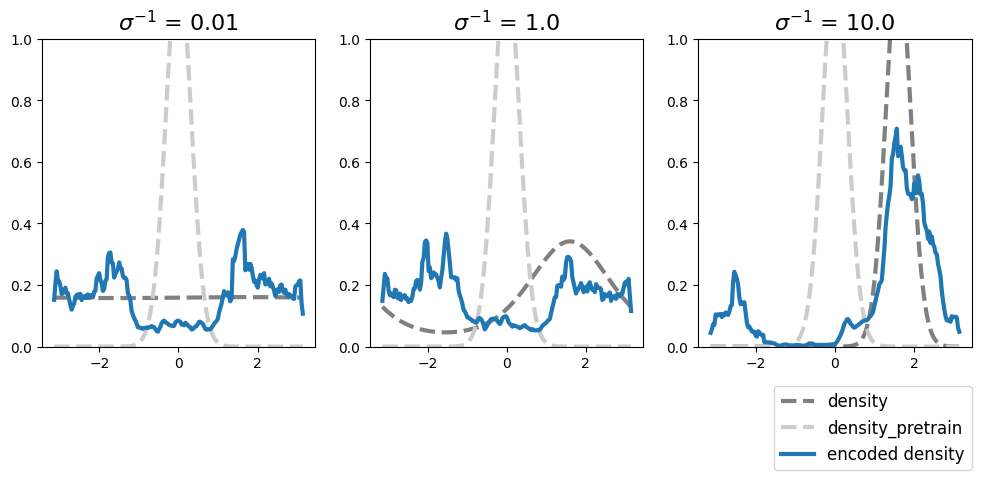

In [56]:
figsize(12,4)
plt.subplots(1,3)

from scipy.signal import savgol_filter

#color_dict = {loss: f'C{i}' for i, loss in enumerate(['angle_diff', 'sq_diff', 'sqrt_diff'])}
plt.ylim([0, 100])


for i, row in enumerate(FI_pretrain.sort_values('kappa').iterrows()):
    row = row[1]
    plt.subplot(1,3,i+1)

    dist = vonmises(loc=1.6, kappa=row['kappa'])
    old_dist = vonmises(loc=0, kappa=10.)
    plt.plot(angles, dist.pdf(angles), '--', color='0.5', linewidth=3, label='density')
    plt.plot(angles, old_dist.pdf(angles), '--', color='0.8', linewidth=3, label='density_pretrain')

    normalized_FI = row['fisher_info']/((row['fisher_info']).sum()*np.pi/100) 

    parameter_dist = results[results.kappa == row['kappa']].iloc[0]['density']

    constraint = parameter_dist / normalized_FI
    normed_constraint = constraint / (constraint.sum() *np.pi /100)
    
    N=5
    plt.plot(angles, np.convolve(normed_constraint,np.ones(N)/N, mode='same'),
              linewidth=3, label='encoded density')
    plt.title('$\sigma^{-1}$ = ' + f'{row['kappa']}', fontsize=16)


    plt.ylim([0,1.])



plt.legend(bbox_to_anchor=(1.03, -.1), fontsize=12)
plt.savefig('constraint_internal.png', dpi = 300, bbox_inches='tight')

<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_3764/4047095963.py:29: SyntaxWarning: invalid escape sequence '\s'
  plt.title('$\sigma^{-1}$ = ' + f'{row['kappa']}', fontsize=16)


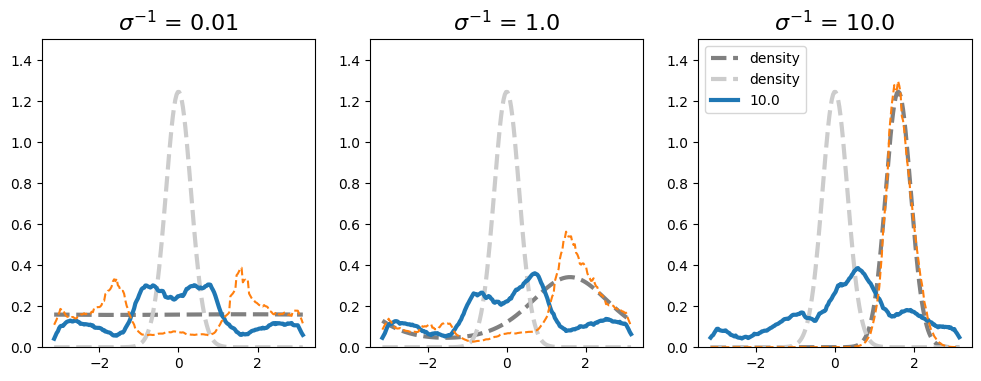

In [13]:
figsize(12,4)
plt.subplots(1,3)

from scipy.signal import savgol_filter

#color_dict = {loss: f'C{i}' for i, loss in enumerate(['angle_diff', 'sq_diff', 'sqrt_diff'])}
plt.ylim([0, 100])


for i, row in enumerate(FI_pretrain.sort_values('kappa').iterrows()):
    row = row[1]
    plt.subplot(1,3,i+1)

    dist = vonmises(loc=1.6, kappa=row['kappa'])
    old_dist = vonmises(loc=0, kappa=10.)
    plt.plot(angles, dist.pdf(angles), '--', color='0.5', linewidth=3, label='density')
    plt.plot(angles, old_dist.pdf(angles), '--', color='0.8', linewidth=3, label='density')

    normalized_root_FI = row['fisher_info']/((row['fisher_info']).sum()*np.pi/100) 
    N=10
    plt.plot(angles, np.convolve(normalized_root_FI, np.ones(N)/N, mode='same'),
              linewidth=3, label=row['kappa'])

    next_dist = dist.pdf(angles) / normalized_root_FI
    next_dist = next_dist / (next_dist.sum() * np.pi/100)
    plt.plot(angles, np.convolve(next_dist, np.ones(N)/N, mode='same'), '--')
    
    
    plt.title('$\sigma^{-1}$ = ' + f'{row['kappa']}', fontsize=16)


    plt.ylim([0,1.5])


plt.legend()

<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_77468/2204876734.py:29: SyntaxWarning: invalid escape sequence '\s'
  plt.title('$\sigma^{-1}$ = ' + f'{row['kappa']}', fontsize=16)


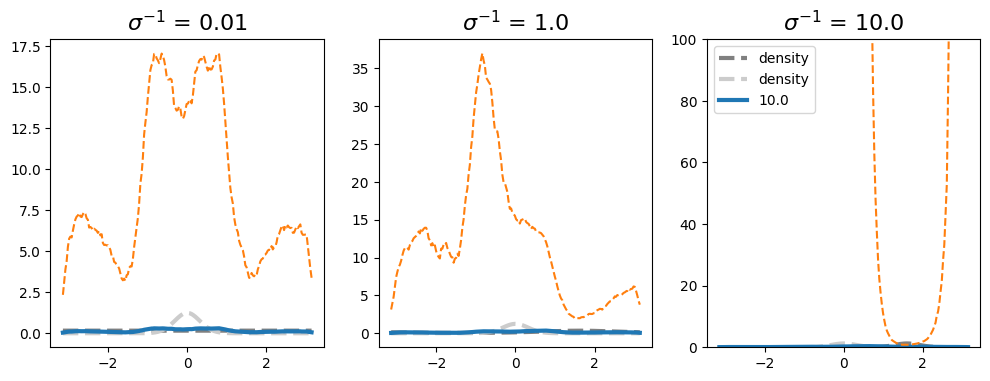

In [97]:
figsize(12,4)
plt.subplots(1,3)

from scipy.signal import savgol_filter

#color_dict = {loss: f'C{i}' for i, loss in enumerate(['angle_diff', 'sq_diff', 'sqrt_diff'])}
plt.ylim([0, 100])


for i, row in enumerate(FI_pretrain.sort_values('kappa').iterrows()):
    row = row[1]
    plt.subplot(1,3,i+1)

    dist = vonmises(loc=1.6, kappa=row['kappa'])
    old_dist = vonmises(loc=0, kappa=10.)
    plt.plot(angles, dist.pdf(angles), '--', color='0.5', linewidth=3, label='density')
    plt.plot(angles, old_dist.pdf(angles), '--', color='0.8', linewidth=3, label='density')

    normalized_root_FI = row['fisher_info']/((row['fisher_info']).sum()*np.pi/100) 
    N=10
    plt.plot(angles, np.convolve(normalized_root_FI, np.ones(N)/N, mode='same'),
              linewidth=3, label=row['kappa'])

    next_dist = dist.pdf(angles) / normalized_root_FI
    constraint = 1. /(next_dist / (next_dist.sum() * np.pi/100))
    plt.plot(angles, np.convolve(constraint, np.ones(N)/N, mode='same'), '--')
    
    
    plt.title('$\sigma^{-1}$ = ' + f'{row['kappa']}', fontsize=16)


    #plt.ylim([0,1.5])


plt.legend()